In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [3]:
import jax
import jax.numpy as np
import jax.tree_util as jtu

key = jax.random.PRNGKey(1)

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)

import jax_md
import equinox as eqx

import jax_morph as jxm
from jax_morph.visualization import draw_circles_divrate, draw_circles_chem, draw_circles_stress, draw_circles_ctype

import matplotlib.pyplot as plt

2023-12-20 14:26:15.050083: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
INTERNAL: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error
2023-12-20 14:26:15.050141: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2461] Execution of replica 0 failed: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error; current tracing scope: custom-call.12; current profiling annotation: XlaModule:#hlo_module=jit_eigh,program_id=178#.


XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error; current tracing scope: custom-call.12; current profiling annotation: XlaModule:#hlo_module=jit_eigh,program_id=178#.

# Cell State

In [1]:
#all new cell states must inherit from jxm.BaseCellState
class CellState(jxm.BaseCellState):
    chemical:           jax.Array
    secretion_rate:     jax.Array
    chemical_grad:      jax.Array
    hidden_state:       jax.Array

NameError: name 'jxm' is not defined

In [ ]:
N_DIM = 2
N_CHEM = 20
N_HIDDEN = 128
N_CTYPES = 1

N = 120
N_ADD = int(N-1)


### Build initial state

disp, shift = jax_md.space.free()

istate = CellState(
    displacement=   disp,
    shift=          shift,
    position=       np.zeros(shape=(N,N_DIM)),
    celltype=       np.zeros(shape=(N,N_CTYPES)).at[0].set(1.),
    radius=         np.zeros(shape=(N,1)).at[0].set(.5),
    division=       np.zeros(shape=(N,1)).at[0].set(1.),
    chemical=       np.zeros(shape=(N,N_CHEM)),
    chemical_grad=  np.zeros(shape=(N,int(N_DIM*N_CHEM))),
    secretion_rate= np.zeros(shape=(N,N_CHEM)).at[0].set(1.),
    hidden_state=   np.zeros(shape=(N,N_HIDDEN))
)

# Model

**NOTE 1:** Every parameter that is passed as a jax array will be differentiated over and subject to optimization. Every parameter that is passed as a python primitive will be treated as a constant.

**NOTE 2:** There is currently no (easy) way to do the opposite in jax-morph, that is to choose *not* to differentiate w.r.t. a jax array. It is possible in principle but doesn't look like we used this feature that much until now, so its introduction is postponed.

In [5]:
key, init_key = jax.random.split(key)


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

model = jxm.Sequential(
    substeps=[
        jxm.env.CellDivision(),

        jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),

        jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=1.),
        # jxm.env.diffusion.ApproxSteadyStateDiffusion(degradation_rate=.8, diffusion_coeff=.5),

        jxm.cell.sensing.LocalChemicalGradients(),

        jxm.cell.GeneNetwork(istate,
                            input_fields=['chemical', 'chemical_grad', 'division', 'radius'],
                            output_fields=['secretion_rate', 'division'],
                            key=init_key,
                            transform_output={'division': lambda s,x: x*jax.nn.sigmoid(50*(s.radius - .45))},
                            expr_level_decay=.8,
                            ),

    ])


# POSSIBLE REASONS FOR NOT WORKING IN GENERAL:
# - sigmoids in the gene network
# - too small number of params in the gene network
# - gradient problems in the gene network (possibly connected to the sigmoids)

In [6]:
# ### WORKS VERY WELL



# key, init_key = jax.random.split(key)


# mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

# model = jxm.Sequential(
#     substeps=[
#         jxm.env.CellDivision(),

#         jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

#         jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),

#         jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=1.), #WORKS LESS WELL, BUT STILL WORKS -- ???
#         # jxm.env.diffusion.ApproxSteadyStateDiffusion(degradation_rate=.8, diffusion_coeff=.5),

#         jxm.cell.sensing.LocalChemicalGradients(),

#         jxm.cell.HiddenStateMLP(istate,
#                                 input_fields=['chemical', 'chemical_grad', 'division', 'radius'],
#                                 key=init_key,
#         ),

#         jxm.cell.SecretionMLP(istate,
#                               input_fields=['hidden_state'],
#                               key=init_key,
#         ),


#         jxm.cell.DivisionMLP(istate,
#                              input_fields=['hidden_state'],
#                              key=init_key,
#                              w_init=jax.nn.initializers.glorot_normal(),
#                              transform_output=lambda s,x: x*jax.nn.sigmoid(50*(s.radius - .45)),
#         ),

        
#     ])

# Training

In [ ]:
EPOCHS = 50
N_EPISODES = 4
N_VAL_EPISODES = 16

COST_FN = jxm.opt.cost_functions.VShape()

GAMMA = .9
LAMBDA = 0.

LOSS = jxm.opt.losses.ReinforceLoss(COST_FN,
                                    n_sim_steps=N_ADD,
                                    n_episodes=N_EPISODES,
                                    n_val_episodes=N_VAL_EPISODES,
                                    gamma=GAMMA,
                                    lambda_l1=LAMBDA,
                                    )


opt_results = jxm.opt.train(model, istate, LOSS, key=key, epochs=EPOCHS)

Loss: 5.06250: 100%|████████████████████████████| 50/50 [01:11<00:00,  1.43s/it]


In [7]:
EPOCHS = 100
N_EPISODES = 8
N_VAL_EPISODES = 16

COST_FN = jxm.opt.cost_functions.MeanSquareY()

GAMMA = .9
LAMBDA = 0.

LOSS = jxm.opt.losses.ReinforceLoss(COST_FN,
                                    n_sim_steps=N_ADD,
                                    n_episodes=N_EPISODES,
                                    n_val_episodes=N_VAL_EPISODES,
                                    gamma=GAMMA,
                                    lambda_l1=LAMBDA,
                                    )


opt_results = jxm.opt.train(model, istate, LOSS, key=key, epochs=EPOCHS)

Loss: 464.60632: 100%|████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


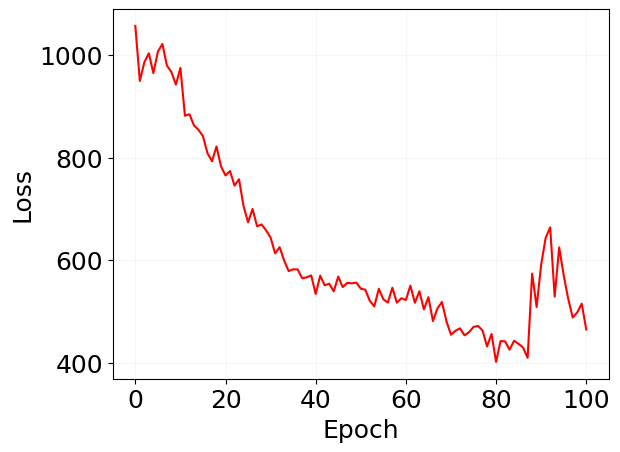

In [8]:
plt.plot(opt_results.loss_aux, 'r')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(alpha=.1);

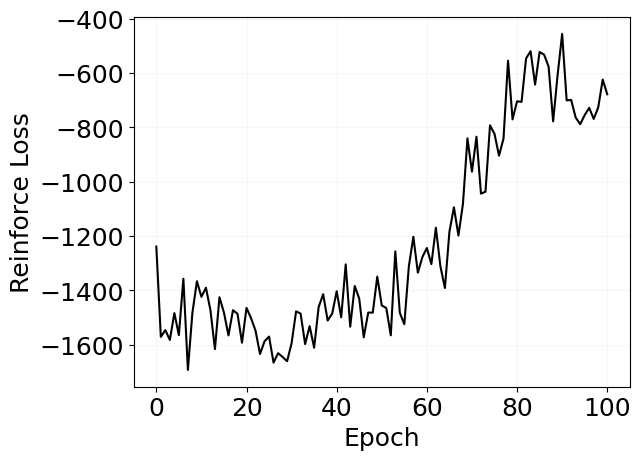

In [9]:
plt.plot(opt_results.loss, 'k')

plt.xlabel('Epoch')
plt.ylabel('Reinforce Loss')

plt.grid(alpha=.1);

In [10]:
def _final_cost_distribution(model, istate, subkeys, n_sim_steps):

    vsim = jax.vmap(jxm.simulate, (None, None, 0, None))

    fstate, _ = vsim(model, istate, subkeys, n_sim_steps)

    cost = (fstate.position[:,:,1]**2).sum(-1)

    return cost.tolist()

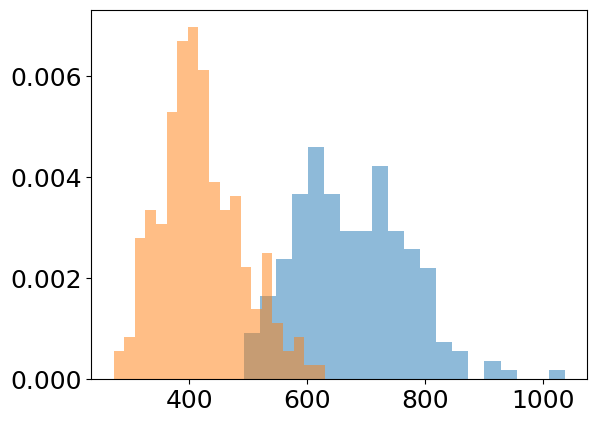

In [11]:
subkeys = np.asarray(jax.random.split(key, 200))

mcost = _final_cost_distribution(model, istate, subkeys, N_ADD)
ocost = _final_cost_distribution(opt_results.model, istate, subkeys, N_ADD)

plt.hist(mcost, bins=20, alpha=.5, density=True)
plt.hist(ocost, bins=20, alpha=.5, density=True);

In [12]:
np.linalg.norm(opt_results.model[-1].interaction_matrix-model[-1].interaction_matrix)

Array(0.48682865, dtype=float64)

# Initial Random Parameters

In [25]:
key, subkey = jax.random.split(key)
ss, _ = jxm.simulate(model, istate, subkey, N_ADD)

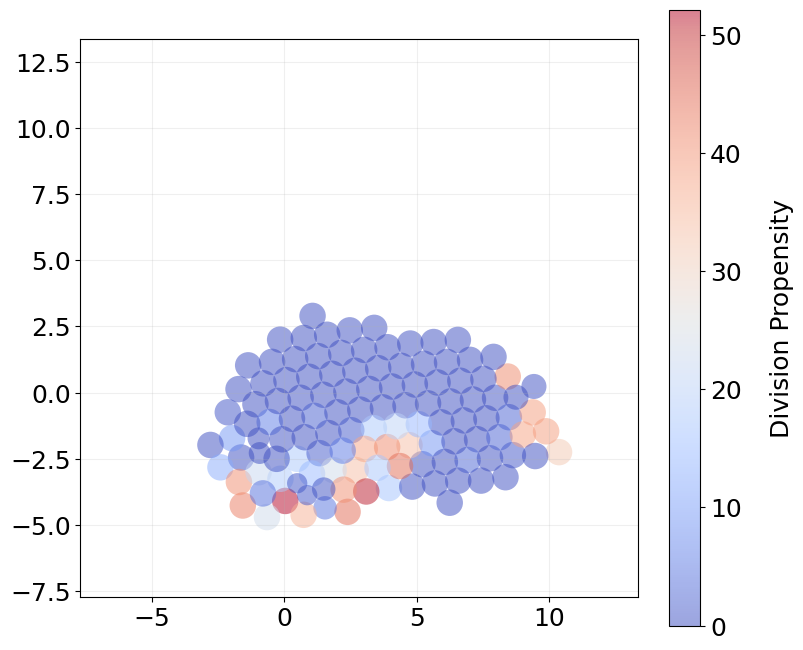

In [26]:
draw_circles_divrate(ss, grid=True);

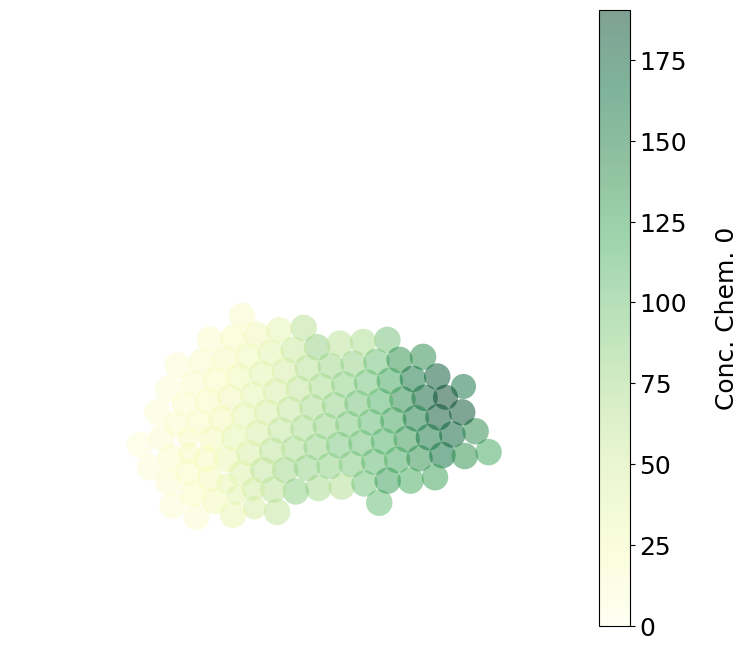

In [27]:
draw_circles_chem(ss, 0);

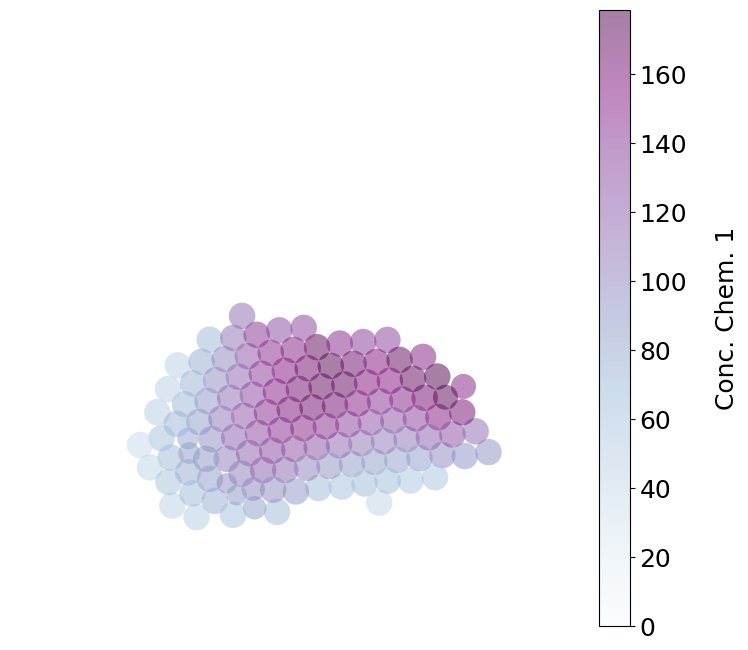

In [28]:
draw_circles_chem(ss, 1);

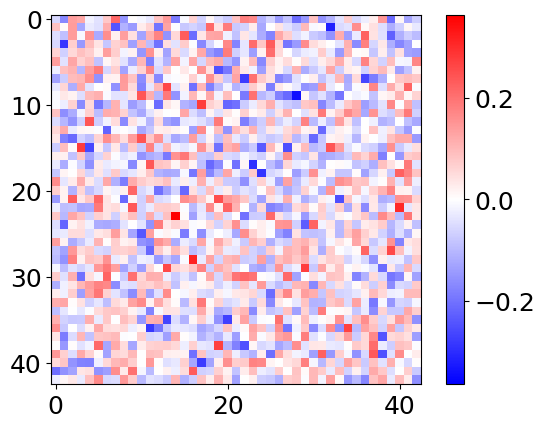

In [29]:
mat = model[-1].interaction_matrix

v = np.max(np.abs(mat))

plt.imshow(mat, cmap='bwr', vmin=-v, vmax=v)
plt.colorbar();

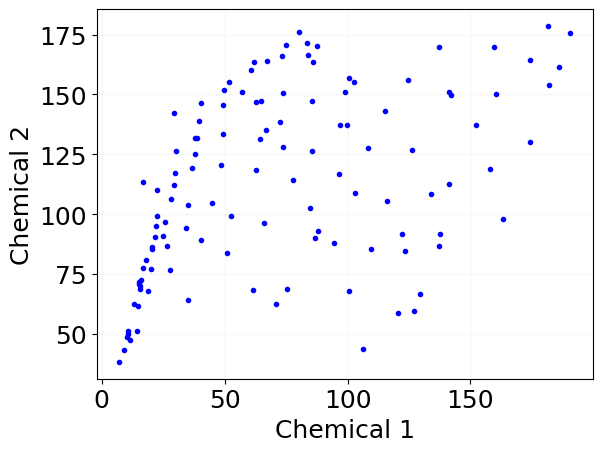

In [30]:
plt.plot(ss.chemical[:,0].tolist(), ss.chemical[:,1].tolist(), 'b.')

plt.xlabel('Chemical 1')
plt.ylabel('Chemical 2')

plt.grid(alpha=.1);

# Optimized Parameters

In [31]:
key, subkey = jax.random.split(key)
s, _ = jxm.simulate(opt_results.model, istate, subkey, N_ADD)

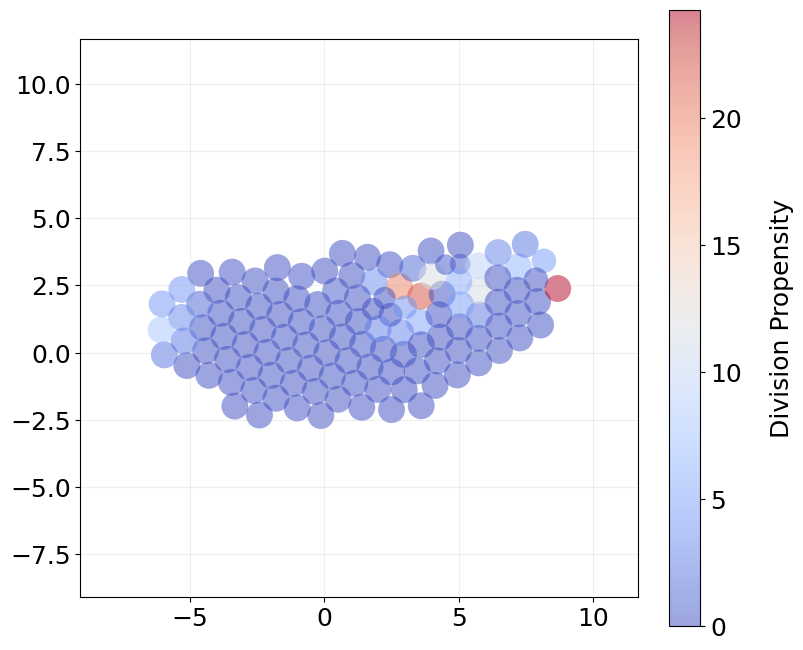

In [32]:
draw_circles_divrate(s, grid=True);

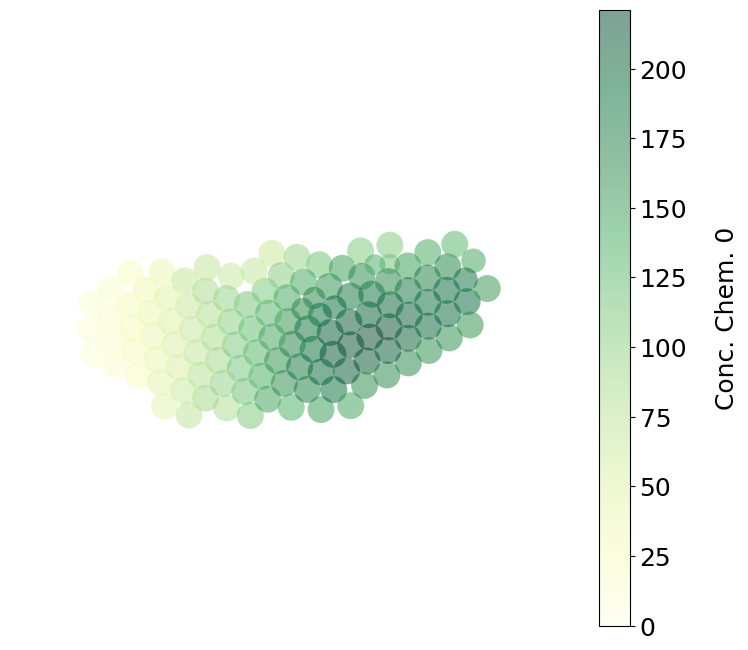

In [33]:
draw_circles_chem(s, 0);

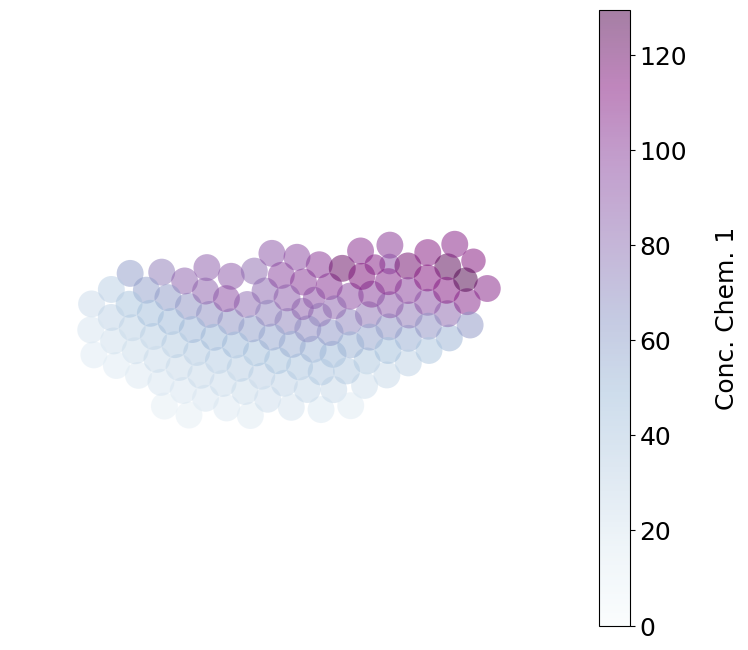

In [34]:
draw_circles_chem(s, 1);

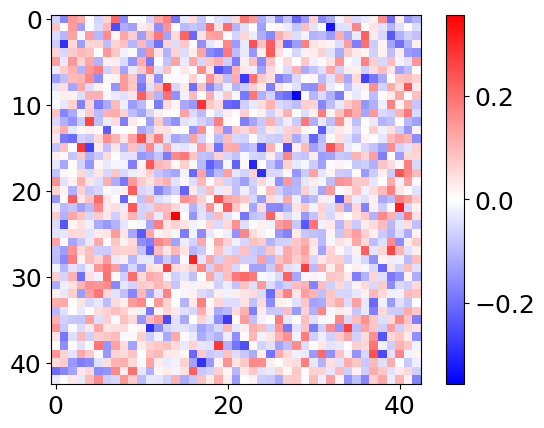

In [35]:
mat = opt_results.model[-1].interaction_matrix

v = np.max(np.abs(mat))

plt.imshow(mat, cmap='bwr', vmin=-v, vmax=v)
plt.colorbar();

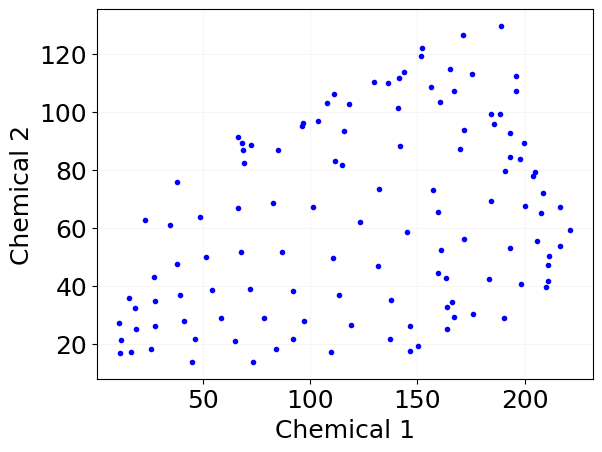

In [36]:
plt.plot(s.chemical[:,0].tolist(), s.chemical[:,1].tolist(), 'b.')

plt.xlabel('Chemical 1')
plt.ylabel('Chemical 2')

plt.grid(alpha=.1);

In [220]:
ss1 = jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=1.)(s)
ss2 = jxm.env.diffusion.ApproxSteadyStateDiffusion(degradation_rate=.8, diffusion_coeff=.5)(s)

In [221]:
ss3, _ = opt_model(s, key=subkey)

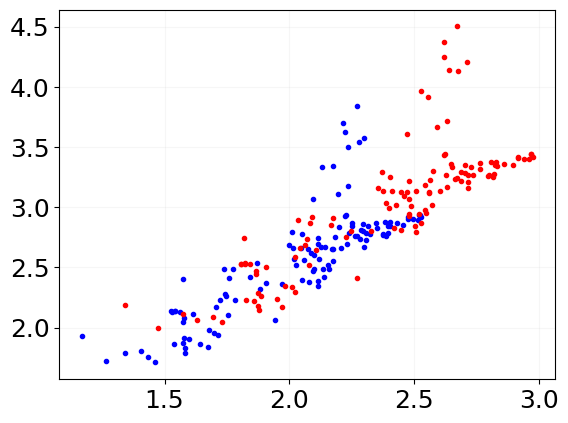

In [222]:
plt.plot(ss1.chemical[:,0].tolist(), ss2.chemical[:,0].tolist(), 'b.')
plt.plot(ss1.chemical[:,1].tolist(), ss2.chemical[:,1].tolist(), 'r.')

plt.grid(alpha=.1);

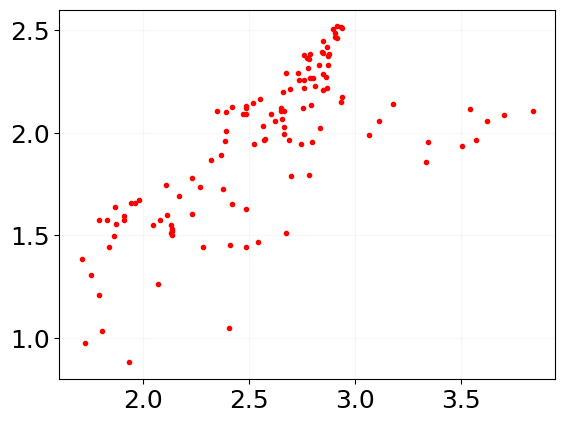

In [223]:
plt.plot(ss2.chemical[:,0].tolist(), ss3.chemical[:,0].tolist(), 'r.')

plt.grid(alpha=.1);
